# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [45]:
#%pip install pymystem3

In [46]:
#загрузим потренциально необходимые документы

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt 
import numpy as np 

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk import ngrams
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# nltk.download('all')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from tqdm.notebook import tqdm
from tqdm import notebook

from pymystem3 import Mystem
m = Mystem()

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle

%matplotlib inline
from nltk.probability import FreqDist
%pip install wordcloud 
from wordcloud import WordCloud

import re
import time
import warnings
warnings.filterwarnings('ignore')
RS = [12345]

Defaulting to user installation because normal site-packages is not writeable


In [47]:
#загрузим данные
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('./toxic_comments.csv')

In [48]:
display(df.head())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [49]:
df.dtypes

Unnamed: 0     int64
text          object
toxic          int64
dtype: object

In [50]:
#посмотрим на дубликаты
display(df.duplicated())

0         False
1         False
2         False
3         False
4         False
          ...  
159287    False
159288    False
159289    False
159290    False
159291    False
Length: 159292, dtype: bool

In [51]:
# посмотрим на пропуски
display(df.isna().sum())

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [52]:
df.shape

(159292, 3)

In [53]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
Unnamed: 0    159292 non-null int64
text          159292 non-null object
toxic         159292 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

In [54]:
# убираем малоинформативный столбец Unnamed:
df= df.drop(['Unnamed: 0'], axis=1)

In [55]:
display(df.head())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


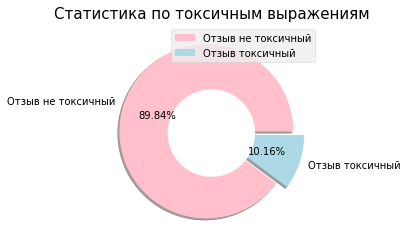

In [56]:
# построим диаграмму по целевому признаку toxic

plt.style.use("bmh")

size = df['toxic'].value_counts()
colors = ['pink', 'lightblue']
labels = "Отзыв не токсичный", "Отзыв токсичный"
explode = [0.06, 0.07] 
donut = plt.Circle((0,0), 0.5, color = 'white')

plt.pie(size, colors = colors, labels = labels, shadow = True, explode = explode, autopct = '%.2f%%')

plt.title('Статистика по токсичным выражениям', fontsize = 15)
p = plt.gcf()

p.gca().add_artist(donut)
plt.legend()
plt.show()

In [57]:
# лемматизация, очистка текстов от лишних знаков

def preprocess_text(text):
    tokenized = nltk.word_tokenize(text)
    joined = ' '.join(tokenized)
    text_only = re.sub(r'[^a-zA-Z]', ' ', joined)
    new_result = ' '.join(text_only.split())
    return new_result


notebook.tqdm.pandas() 

df['text_clear'] = df['text'].progress_apply(preprocess_text)


In [58]:
df.head()

,text,toxic,text_clear
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I ca n t make any real suggestions on imp...
4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


(-0.5, 399.5, 199.5, -0.5)

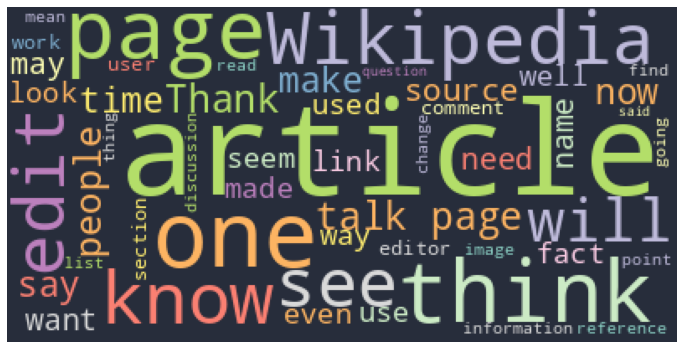

In [59]:
#визуализируем облако слов с наибольшей частотой использования в тексте: чем чаще встречается слово, тем большим размером шрифта оно написано 
text = ' '.join(df['text'])
cloud = WordCloud(contour_width=12,background_color='#272d3b', colormap='Set3', max_words=50).generate(text)
plt.figure(figsize=(12,15))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

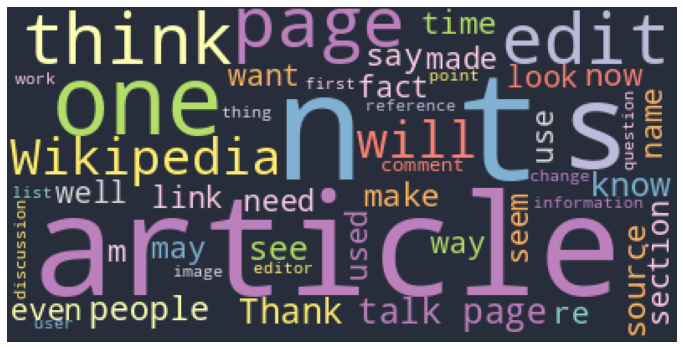

In [60]:
text = ' '.join(df['text_clear'])
cloud = WordCloud(contour_width=12,background_color='#272d3b', colormap='Set3', max_words=50).generate(text)
plt.figure(figsize=(12,15))
plt.imshow(cloud)
plt.axis('off')

In [61]:
#разделим на выборки
X_train_clear, X_test_clear = train_test_split(df['text_clear'], test_size=.25, random_state=12345)
y_train, y_test = train_test_split(df['toxic'], test_size=.25, random_state=12345)

In [62]:
X_train_clear.shape, X_test_clear.shape,y_train.shape, y_test.shape

((119469,), (39823,), (119469,), (39823,))

In [63]:
#убираем стоп-слова
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(analyzer='word',stop_words= 'english')

In [64]:
X_train = count_tf_idf.fit_transform(X_train_clear)
X_test = count_tf_idf.transform(X_test_clear)
X_train.shape, X_test.shape

((119469, 141843), (39823, 141843))

Данные проекта:
 - предварительно обработаны;
 - поделены на две выборки: обучающую и тестовую.

## Обучение

In [65]:
score = make_scorer(f1_score)

In [66]:
n_splits = 3

***RandomForestClassifier***

In [67]:
#для информации: class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, 
#min_samples_split=2, #min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, 
#bootstrap=True, #oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [68]:
%%time

params = {"max_depth": [5, 10, 15], 
          "n_estimators": [30, 90, 150], 
          "random_state": RS, 
          "class_weight": ['balanced']
         }
model_rfc = RandomForestClassifier()

model_rfc_rs = RandomizedSearchCV(model_rfc, cv=n_splits, scoring=score, param_distributions=params)
model_rfc_rs.fit(X_train, y_train)

print('лучший результат F1:', model_rfc_rs.best_score_)
print('*'*50)
model_rfc_rs.best_params_

лучший результат F1: 0.4015131824333926
**************************************************
CPU times: user 5min 28s, sys: 1.26 s, total: 5min 29s
Wall time: 5min 26s


{'random_state': 12345,
 'n_estimators': 150,
 'max_depth': 15,
 'class_weight': 'balanced'}

***LogisticRegression***

In [69]:
#для информации: class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True,
#intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False,
# n_jobs=None, l1_ratio=None)

In [70]:
%%time

params_lr = {"class_weight": ['balanced'], 
             "random_state": [12345],
             "max_iter": [100, 150, 200],
             "C": [0.5, 1.0, 1.5]
            }
model_lr = LogisticRegression()
model_lr_rs = RandomizedSearchCV(
    model_lr, cv=n_splits, scoring=score, 
    param_distributions=params_lr, n_iter=n_splits, verbose=True
)
model_lr_rs.fit(X_train, y_train)

print('лучший результат F1:', model_lr_rs.best_score_)
print('*'*50)
model_lr_rs.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
лучший результат F1: 0.753862785528237
**************************************************
CPU times: user 27.8 s, sys: 3 s, total: 30.8 s
Wall time: 26.9 s


{'random_state': 12345, 'max_iter': 150, 'class_weight': 'balanced', 'C': 1.5}

In [71]:
table = pd.DataFrame(index=['F1'], columns=['RandomForestClassifier','LogisticRegression'])
table['RandomForestClassifier'] = model_rfc_rs.best_score_
table['LogisticRegression'] = model_lr_rs.best_score_
table.T

,F1
RandomForestClassifier,0.401513
LogisticRegression,0.753863


In [72]:
# проверка лучшей модели LogisticRegression на тестовой выборке

predict = model_lr_rs.predict(X_test)
f1_score(y_test, predict)

0.7615894039735099

## Выводы

- данные загружены, предобработаны, поделены на две выборки: обучающую и тестовую;
- при обучении были подобраны параметры и обучены модели;
- Модель LogisticRegression показала лучшие результаты согласно требованиям, в том числе на тестовой выборке.